In [3]:
# Cell 1: Import and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

In [4]:
#  Load the datasets
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=column_names)

movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 
                'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movie_columns, encoding='latin-1')

In [5]:
#  Display basic information about the datasets
print("Ratings dataset shape:", ratings.shape)
print("Movies dataset shape:", movies.shape)
print("\nFirst few rows of ratings data:")
print(ratings.head())
print("\nFirst few rows of movies data:")
print(movies[['movie_id', 'title']].head())

Ratings dataset shape: (100000, 4)
Movies dataset shape: (1682, 24)

First few rows of ratings data:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

First few rows of movies data:
   movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)


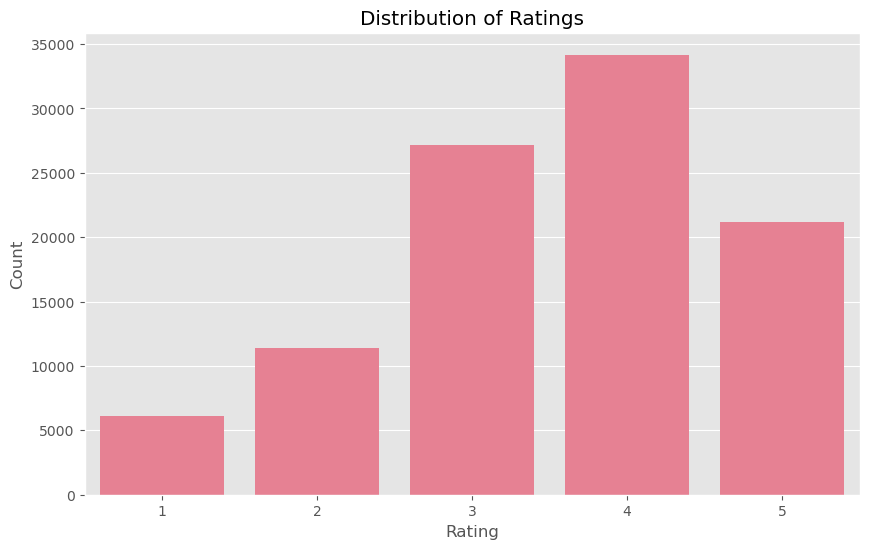

In [6]:
#Exploratory Data Analysis (EDA) - Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [7]:
n_users = ratings.user_id.nunique()
n_movies = ratings.item_id.nunique()
print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")

Number of unique users: 943
Number of unique movies: 1682


In [8]:
most_rated = ratings.item_id.value_counts().head(10)
most_rated_titles = [movies[movies.movie_id == id].title.values[0] for id in most_rated.index]
print("\nTop 10 most rated movies:")
for i, title in enumerate(most_rated_titles, 1):
    print(f"{i}. {title}")


Top 10 most rated movies:
1. Star Wars (1977)
2. Contact (1997)
3. Fargo (1996)
4. Return of the Jedi (1983)
5. Liar Liar (1997)
6. English Patient, The (1996)
7. Scream (1996)
8. Toy Story (1995)
9. Air Force One (1997)
10. Independence Day (ID4) (1996)


In [9]:
most_active = ratings.user_id.value_counts().head(10)
print("\nTop 10 most active users (by number of ratings):")
print(most_active)


Top 10 most active users (by number of ratings):
user_id
405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
Name: count, dtype: int64


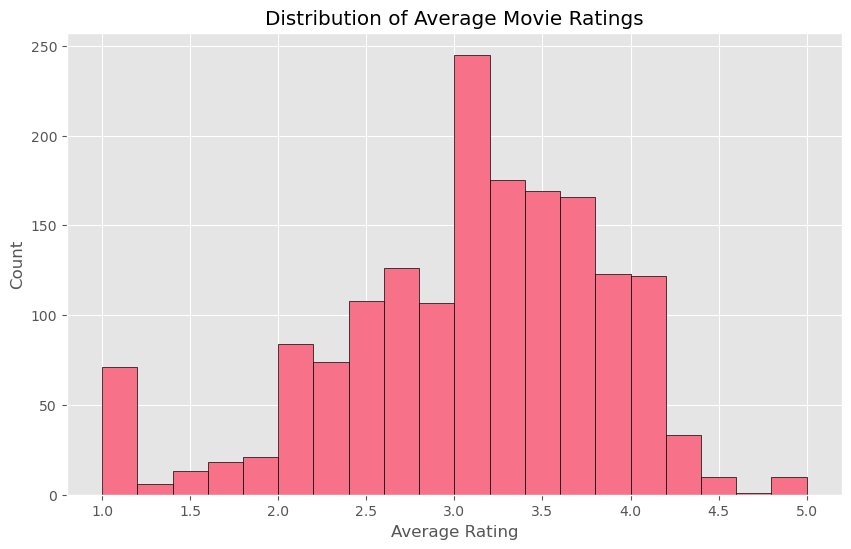

In [10]:
avg_rating = ratings.groupby('item_id')['rating'].mean()
plt.figure(figsize=(10, 6))
plt.hist(avg_rating, bins=20, edgecolor='black')
plt.title('Distribution of Average Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

In [11]:
user_item_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating')
user_item_matrix = user_item_matrix.fillna(0)

print("User-Item Matrix shape:", user_item_matrix.shape)
print("\nFirst few rows of the user-item matrix:")
user_item_matrix.head()

User-Item Matrix shape: (943, 1682)

First few rows of the user-item matrix:


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("User-User Similarity Matrix shape:", user_similarity_df.shape)
user_similarity_df.head()

User-User Similarity Matrix shape: (943, 943)


user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941


In [14]:
def get_user_recommendations(user_id, num_recommendations=5, user_sim_matrix=user_similarity_df, ratings_matrix=user_item_matrix):
    if user_id not in ratings_matrix.index:
        return f"User {user_id} not found in the dataset."
    
    user_similarities = user_sim_matrix[user_id].sort_values(ascending=False)
    user_similarities = user_similarities.drop(user_id)
    top_similar_users = user_similarities.head(10).index
    
    user_ratings = ratings_matrix.loc[user_id]
    unseen_movies = user_ratings[user_ratings == 0].index
    
    recommendation_scores = {}
    
    for movie in unseen_movies:
        weighted_sum = 0
        similarity_sum = 0
        
        for other_user in top_similar_users:
            if ratings_matrix.loc[other_user, movie] > 0:
                weighted_sum += user_sim_matrix.loc[user_id, other_user] * ratings_matrix.loc[other_user, movie]
                similarity_sum += user_sim_matrix.loc[user_id, other_user]
        
        if similarity_sum > 0:
            recommendation_scores[movie] = weighted_sum / similarity_sum
    
    recommended_movies = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    
    recommended_movie_titles = []
    for movie_id, score in recommended_movies:
        movie_title = movies[movies.movie_id == movie_id].title.values[0]
        recommended_movie_titles.append((movie_title, score))
    
    return recommended_movie_titles

In [15]:
sample_user_id = 150
recommendations = get_user_recommendations(sample_user_id, num_recommendations=10)

print(f"Top 10 recommendations for user {sample_user_id}:")
for i, (title, score) in enumerate(recommendations, 1):
    print(f"{i}. {title} (score: {score:.4f})")

Top 10 recommendations for user 150:
1. When We Were Kings (1996) (score: 5.0000)
2. Mystery Science Theater 3000: The Movie (1996) (score: 5.0000)
3. Good Will Hunting (1997) (score: 5.0000)
4. Deconstructing Harry (1997) (score: 5.0000)
5. Courage Under Fire (1996) (score: 4.5438)
6. Amistad (1997) (score: 4.4899)
7. Cold Comfort Farm (1995) (score: 4.4837)
8. Ice Storm, The (1997) (score: 4.4734)
9. Sense and Sensibility (1995) (score: 4.3377)
10. Bottle Rocket (1996) (score: 4.3143)


In [16]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 80000
Test set size: 20000


In [17]:
train_matrix = train_data.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)
test_matrix = test_data.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)

all_users = list(set(train_matrix.index) | set(test_matrix.index))
all_movies = list(set(train_matrix.columns) | set(test_matrix.columns))

train_matrix = train_matrix.reindex(index=all_users, columns=all_movies, fill_value=0)
test_matrix = test_matrix.reindex(index=all_users, columns=all_movies, fill_value=0)

print(f"Training matrix shape: {train_matrix.shape}")
print(f"Test matrix shape: {test_matrix.shape}")

Training matrix shape: (943, 1682)
Test matrix shape: (943, 1682)


In [18]:
train_user_similarity = cosine_similarity(train_matrix)
train_user_similarity_df = pd.DataFrame(
    train_user_similarity, 
    index=train_matrix.index, 
    columns=train_matrix.index
)

In [19]:

def precision_at_k(user_id, k=5, train_matrix=train_matrix, test_matrix=test_matrix, 
                  user_sim_matrix=train_user_similarity_df):
    if user_id not in test_matrix.index:
        return 0
    
    test_ratings = test_matrix.loc[user_id]
    relevant_movies = set(test_ratings[test_ratings > 0].index)
    
    if not relevant_movies:
        return 0
    
    recommendations = get_user_recommendations(
        user_id, num_recommendations=k, 
        user_sim_matrix=user_sim_matrix, 
        ratings_matrix=train_matrix
    )
    
    if isinstance(recommendations, str):
        return 0
    
    recommended_movies = set()
    for title, score in recommendations:
        movie_id = movies[movies.title == title].movie_id.values[0]
        recommended_movies.add(movie_id)
    
    relevant_and_recommended = relevant_movies.intersection(recommended_movies)
    precision = len(relevant_and_recommended) / k
    
    return precision

In [20]:
sample_users = list(test_matrix.index)[:100]

precision_5_scores = []
precision_10_scores = []

for user in sample_users:
    precision_5 = precision_at_k(user, k=5)
    precision_10 = precision_at_k(user, k=10)
    
    precision_5_scores.append(precision_5)
    precision_10_scores.append(precision_10)

avg_precision_5 = np.mean(precision_5_scores)
avg_precision_10 = np.mean(precision_10_scores)

print(f"Average Precision@5: {avg_precision_5:.4f}")
print(f"Average Precision@10: {avg_precision_10:.4f}")

Average Precision@5: 0.0580
Average Precision@10: 0.0550


In [22]:
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity, 
    index=user_item_matrix.columns, 
    columns=user_item_matrix.columns
)

print("Item-Item Similarity Matrix shape:", item_similarity_df.shape)
item_similarity_df.head()

Item-Item Similarity Matrix shape: (1682, 1682)


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
2,0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
3,0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
4,0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
5,0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


In [23]:
def get_item_recommendations(movie_id, num_recommendations=5, item_sim_matrix=item_similarity_df):
    if movie_id not in item_sim_matrix.index:
        return f"Movie {movie_id} not found in the dataset."
    
    movie_similarities = item_sim_matrix[movie_id].sort_values(ascending=False)
    movie_similarities = movie_similarities.drop(movie_id)
    top_similar_movies = movie_similarities.head(num_recommendations)
    
    similar_movie_titles = []
    for similar_movie_id, score in top_similar_movies.items():
        movie_title = movies[movies.movie_id == similar_movie_id].title.values[0]
        similar_movie_titles.append((movie_title, score))
    
    return similar_movie_titles

In [24]:
sample_movie_id = 50
sample_movie_title = movies[movies.movie_id == sample_movie_id].title.values[0]
similar_movies = get_item_recommendations(sample_movie_id, num_recommendations=5)

print(f"Movies similar to '{sample_movie_title}':")
for i, (title, score) in enumerate(similar_movies, 1):
    print(f"{i}. {title} (similarity: {score:.4f})")

Movies similar to 'Star Wars (1977)':
1. Return of the Jedi (1983) (similarity: 0.8845)
2. Raiders of the Lost Ark (1981) (similarity: 0.7649)
3. Empire Strikes Back, The (1980) (similarity: 0.7498)
4. Toy Story (1995) (similarity: 0.7346)
5. Godfather, The (1972) (similarity: 0.6973)


In [25]:
def get_user_recs_item_based(user_id, num_recommendations=5, ratings_matrix=user_item_matrix, item_sim_matrix=item_similarity_df):
    if user_id not in ratings_matrix.index:
        return f"User {user_id} not found in the dataset."
    
    user_ratings = ratings_matrix.loc[user_id]
    highly_rated_movies = user_ratings[user_ratings >= 4].index
    
    if len(highly_rated_movies) == 0:
        highly_rated_movies = user_ratings[user_ratings > 0].index
    
    unseen_movies = user_ratings[user_ratings == 0].index
    
    recommendation_scores = {}
    
    for unseen_movie in unseen_movies:
        total_score = 0
        total_similarity = 0
        
        for rated_movie in highly_rated_movies:
            if rated_movie in item_sim_matrix.index and unseen_movie in item_sim_matrix.columns:
                similarity = item_sim_matrix.loc[rated_movie, unseen_movie]
                rating = ratings_matrix.loc[user_id, rated_movie]
                
                total_score += similarity * rating
                total_similarity += abs(similarity)
        
        if total_similarity > 0:
            recommendation_scores[unseen_movie] = total_score / total_similarity
    
    recommended_movies = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    
    recommended_movie_titles = []
    for movie_id, score in recommended_movies:
        movie_title = movies[movies.movie_id == movie_id].title.values[0]
        recommended_movie_titles.append((movie_title, score))
    
    return recommended_movie_titles

In [26]:
sample_user_id = 150
item_based_recs = get_user_recs_item_based(sample_user_id, num_recommendations=10)

print(f"Item-based recommendations for user {sample_user_id}:")
for i, (title, score) in enumerate(item_based_recs, 1):
    print(f"{i}. {title} (score: {score:.4f})")

Item-based recommendations for user 150:
1. Condition Red (1995) (score: 4.8217)
2. Death in Brunswick (1991) (score: 4.7140)
3. Shadows (Cienie) (1988) (score: 4.7125)
4. The Courtyard (1995) (score: 4.7125)
5. Yankee Zulu (1994) (score: 4.7125)
6. Hostile Intentions (1994) (score: 4.7125)
7. Tigrero: A Film That Was Never Made (1994) (score: 4.7125)
8. Eye of Vichy, The (Oeil de Vichy, L') (1993) (score: 4.7125)
9. Promise, The (Versprechen, Das) (1994) (score: 4.7125)
10. To Cross the Rubicon (1991) (score: 4.7125)


In [27]:
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
decomposed_matrix = svd.fit_transform(user_item_matrix)

print(f"Original matrix shape: {user_item_matrix.shape}")
print(f"Decomposed matrix shape: {decomposed_matrix.shape}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

Original matrix shape: (943, 1682)
Decomposed matrix shape: (943, 50)
Explained variance ratio: 0.5235


In [28]:
print("U matrix (user features) shape:", decomposed_matrix.shape)
print("Sigma (singular values) shape:", svd.singular_values_.shape)
print("Vt matrix (movie features) shape:", svd.components_.shape)

U matrix (user features) shape: (943, 50)
Sigma (singular values) shape: (50,)
Vt matrix (movie features) shape: (50, 1682)


In [29]:
predicted_ratings = np.dot(decomposed_matrix, svd.components_)
predicted_ratings_df = pd.DataFrame(
    predicted_ratings, 
    index=user_item_matrix.index, 
    columns=user_item_matrix.columns
)

print("Predicted ratings matrix shape:", predicted_ratings_df.shape)
predicted_ratings_df.head()

Predicted ratings matrix shape: (943, 1682)


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.107651,2.517427,1.380815,2.980384,1.608721,1.750464,5.131549,1.615031,3.013657,2.978584,...,0.076903,-0.032477,-0.033798,-0.022532,0.079559,0.001434,0.004302,0.002868,0.044750,0.068175
2,2.055177,0.018480,-0.040560,0.577979,0.095909,0.329084,0.791529,0.198524,2.035170,0.575685,...,0.022124,0.013903,-0.004798,-0.003199,-0.019724,0.004629,0.013886,0.009257,0.027885,-0.018599
3,0.306473,-0.147295,-0.110987,-0.284082,0.067498,-0.005538,0.025827,0.577107,-0.241616,0.386882,...,-0.020658,-0.006683,0.056630,0.037753,-0.014570,0.014828,0.044484,0.029656,-0.002609,-0.002470
4,0.107305,-0.297067,0.045807,0.189322,0.059119,-0.130069,0.101155,-0.085816,-0.070552,-0.158555,...,-0.003696,0.006513,0.011490,0.007660,0.004451,0.006005,0.018015,0.012010,-0.009072,-0.031777
5,4.184258,2.049577,-0.138803,1.128229,0.776645,0.070275,1.705621,0.635517,1.067316,0.247696,...,0.010844,-0.093746,-0.040286,-0.026858,-0.030547,-0.002485,-0.007456,-0.004971,-0.017851,-0.011578


In [30]:
def get_svd_recommendations(user_id, num_recommendations=5, predicted_ratings=predicted_ratings_df, original_ratings=user_item_matrix):
    if user_id not in predicted_ratings.index:
        return f"User {user_id} not found in the dataset."
    
    user_predicted_ratings = predicted_ratings.loc[user_id]
    user_original_ratings = original_ratings.loc[user_id]
    unseen_movies = user_original_ratings[user_original_ratings == 0].index
    
    unseen_predicted_ratings = user_predicted_ratings[unseen_movies]
    top_movies = unseen_predicted_ratings.sort_values(ascending=False).head(num_recommendations)
    
    recommended_movie_titles = []
    for movie_id, score in top_movies.items():
        movie_title = movies[movies.movie_id == movie_id].title.values[0]
        recommended_movie_titles.append((movie_title, score))
    
    return recommended_movie_titles

In [31]:
#Test the SVD recommendation function
sample_user_id = 150
svd_recs = get_svd_recommendations(sample_user_id, num_recommendations=10)

print(f"SVD-based recommendations for user {sample_user_id}:")
for i, (title, score) in enumerate(svd_recs, 1):
    print(f"{i}. {title} (predicted rating: {score:.4f})")


SVD-based recommendations for user 150:
1. Twelve Monkeys (1995) (predicted rating: 2.1496)
2. Rock, The (1996) (predicted rating: 1.8325)
3. People vs. Larry Flynt, The (1996) (predicted rating: 1.5627)
4. Dead Man Walking (1995) (predicted rating: 1.5257)
5. Game, The (1997) (predicted rating: 1.5225)
6. Boogie Nights (1997) (predicted rating: 1.3344)
7. Big Night (1996) (predicted rating: 1.3128)
8. Mr. Holland's Opus (1995) (predicted rating: 1.2859)
9. Grosse Pointe Blank (1997) (predicted rating: 1.2806)
10. Beautiful Girls (1996) (predicted rating: 1.2539)


In [32]:
#Compare recommendations from different methods
print("COMPARISON OF RECOMMENDATION METHODS")
print("====================================\n")

print("User-Based Collaborative Filtering Recommendations:")
user_based_recs = get_user_recommendations(sample_user_id, num_recommendations=5)
for i, (title, score) in enumerate(user_based_recs, 1):
    print(f"{i}. {title} (score: {score:.4f})")

print("\nItem-Based Collaborative Filtering Recommendations:")
item_based_recs = get_user_recs_item_based(sample_user_id, num_recommendations=5)
for i, (title, score) in enumerate(item_based_recs, 1):
    print(f"{i}. {title} (score: {score:.4f})")

print("\nSVD-Based Recommendations:")
svd_recs = get_svd_recommendations(sample_user_id, num_recommendations=5)
for i, (title, score) in enumerate(svd_recs, 1):
    print(f"{i}. {title} (predicted rating: {score:.4f})")

COMPARISON OF RECOMMENDATION METHODS

User-Based Collaborative Filtering Recommendations:
1. When We Were Kings (1996) (score: 5.0000)
2. Mystery Science Theater 3000: The Movie (1996) (score: 5.0000)
3. Good Will Hunting (1997) (score: 5.0000)
4. Deconstructing Harry (1997) (score: 5.0000)
5. Courage Under Fire (1996) (score: 4.5438)

Item-Based Collaborative Filtering Recommendations:
1. Condition Red (1995) (score: 4.8217)
2. Death in Brunswick (1991) (score: 4.7140)
3. Shadows (Cienie) (1988) (score: 4.7125)
4. The Courtyard (1995) (score: 4.7125)
5. Yankee Zulu (1994) (score: 4.7125)

SVD-Based Recommendations:
1. Twelve Monkeys (1995) (predicted rating: 2.1496)
2. Rock, The (1996) (predicted rating: 1.8325)
3. People vs. Larry Flynt, The (1996) (predicted rating: 1.5627)
4. Dead Man Walking (1995) (predicted rating: 1.5257)
5. Game, The (1997) (predicted rating: 1.5225)


In [34]:
# Cell X: Calculate and display the top 10 most rated movies
# Calculate the number of ratings per movie
movie_ratings_count = ratings['item_id'].value_counts().head(10)

# Get the titles for these movies
most_rated_movies = []
for movie_id in movie_ratings_count.index:
    title = movies[movies.movie_id == movie_id]['title'].values[0]
    most_rated_movies.append(title)

# Create a DataFrame for a clean, presentable table
most_rated_df = pd.DataFrame({
    'Movie Title': most_rated_movies,
    'Number of Ratings': movie_ratings_count.values
})

# Display the table with proper indexing (rank 1, 2, 3...)
most_rated_df.index = range(1, 11)
print("Table 1: Top 10 Most Rated Movies")
print(most_rated_df.to_string(index=True, index_names=True))

Table 1: Top 10 Most Rated Movies
                      Movie Title  Number of Ratings
1                Star Wars (1977)                583
2                  Contact (1997)                509
3                    Fargo (1996)                508
4       Return of the Jedi (1983)                507
5                Liar Liar (1997)                485
6     English Patient, The (1996)                481
7                   Scream (1996)                478
8                Toy Story (1995)                452
9            Air Force One (1997)                431
10  Independence Day (ID4) (1996)                429


In [35]:
# Cell X: Function to calculate precision at K for SVD model
def precision_at_k_svd(user_id, k=5, train_matrix=train_matrix, test_matrix=test_matrix, 
                      predicted_ratings_df=predicted_ratings_df, movies_df=movies):
    """
    Calculate precision at K for a given user using SVD predictions.
    
    Parameters:
    user_id (int): ID of the user
    k (int): Number of recommendations to consider
    train_matrix (DataFrame): Training user-item matrix
    test_matrix (DataFrame): Test user-item matrix
    predicted_ratings_df (DataFrame): Predicted ratings from SVD
    movies_df (DataFrame): Movies dataframe with titles
    
    Returns:
    float: Precision at K for the user using SVD
    """
    # Check if user exists in test set
    if user_id not in test_matrix.index:
        return 0
    
    # Get movies the user rated in test set (relevant items)
    test_ratings = test_matrix.loc[user_id]
    relevant_movies = set(test_ratings[test_ratings > 0].index)
    
    if not relevant_movies:
        return 0
    
    # Get user's predicted ratings
    user_predicted_ratings = predicted_ratings_df.loc[user_id]
    
    # Get movies the user hasn't rated in the training data
    user_train_ratings = train_matrix.loc[user_id]
    unseen_movies = user_train_ratings[user_train_ratings == 0].index
    
    # Filter predicted ratings to only unseen movies
    unseen_predicted_ratings = user_predicted_ratings[unseen_movies]
    
    # Get top K movies with highest predicted ratings
    top_movies = unseen_predicted_ratings.sort_values(ascending=False).head(k).index
    
    # Calculate precision
    relevant_and_recommended = relevant_movies.intersection(set(top_movies))
    precision = len(relevant_and_recommended) / k
    
    return precision

# Cell Y: Calculate average precision at K for SVD model
svd_precision_5_scores = []
svd_precision_10_scores = []

for user in sample_users:
    svd_precision_5 = precision_at_k_svd(user, k=5)
    svd_precision_10 = precision_at_k_svd(user, k=10)
    
    svd_precision_5_scores.append(svd_precision_5)
    svd_precision_10_scores.append(svd_precision_10)

avg_svd_precision_5 = np.mean(svd_precision_5_scores)
avg_svd_precision_10 = np.mean(svd_precision_10_scores)

print(f"SVD Average Precision@5: {avg_svd_precision_5:.4f}")
print(f"SVD Average Precision@10: {avg_svd_precision_10:.4f}")

SVD Average Precision@5: 0.6920
SVD Average Precision@10: 0.5770
